# Coronavirus
Statistics about coronavirus in Czechia.  
Filip Gregor, 2020 

In [109]:
tests = "https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/nakazeni-vyleceni-umrti-testy.csv"
daily_cases = "https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/kraj-okres-nakazeni-vyleceni-umrti.csv"

Import python libraries

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np
from lmfit.models import ExponentialModel
from lmfit.models import StepModel
import calendar
import matplotlib.dates as mdates
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

Read the data and save them into panda dataframe.

In [111]:
corona = pd.read_csv(tests)
# Translate column headers into english. 
corona = corona.rename({
    'datum' : 'date',
    'kumulativni_pocet_nakazenych' : 'positive_acc',
    'kumulativni_pocet_vylecenych' : 'cured',
    'kumulativni_pocet_umrti' : 'deaths',
    'kumulativni_pocet_testu' : 'tests',
}, axis = 1)
corona.head()

,date,positive_acc,cured,deaths,tests,kumulativni_pocet_ag_testu,prirustkovy_pocet_nakazenych,prirustkovy_pocet_vylecenych,prirustkovy_pocet_umrti,prirustkovy_pocet_provedenych_testu,prirustkovy_pocet_provedenych_ag_testu
0,2020-01-27,0,0,0,20,0,0,0,0,20,0
1,2020-01-28,0,0,0,28,0,0,0,0,8,0
2,2020-01-29,0,0,0,33,0,0,0,0,5,0
3,2020-01-30,0,0,0,34,0,0,0,0,1,0
4,2020-01-31,0,0,0,37,0,0,0,0,3,0


Change the 'date' column into datetime datatype, sort values by date and reset indexes.

In [112]:
# Convert date to datetype 
corona['date'] = pd.to_datetime(corona['date'], format='%Y-%m-%d')

# Sort values by date and reset indexes
corona.sort_values('date')
corona = corona.reset_index(drop=True)
corona.tail()

,date,positive_acc,cured,deaths,tests,kumulativni_pocet_ag_testu,prirustkovy_pocet_nakazenych,prirustkovy_pocet_vylecenych,prirustkovy_pocet_umrti,prirustkovy_pocet_provedenych_testu,prirustkovy_pocet_provedenych_ag_testu
931,2022-08-15,4015179,3959586,40675,21636458,33756389,2874,2313,8,5587,5185
932,2022-08-16,4017978,3960096,40682,21641948,33760077,2799,510,7,5490,3688
933,2022-08-17,4020375,3960530,40696,21647038,33763504,2397,434,14,5090,3427
934,2022-08-18,4022273,3963956,40711,21651248,33767114,1898,3426,15,4210,3610
935,2022-08-19,4024378,3966340,40714,21656043,33770383,2105,2384,3,4795,3269


Create new column with daily cases and daily tests, also one with total cases at one time(total_acc - cured).

In [113]:
corona['positive_curr'] = corona['positive_acc'] - corona['cured']
corona['daily_positives'] = corona['positive_acc'] - corona['positive_acc'].shift(1)
corona['daily_tests'] = corona['tests'] - corona['tests'].shift(1)
corona.tail()

,date,positive_acc,cured,deaths,tests,kumulativni_pocet_ag_testu,prirustkovy_pocet_nakazenych,prirustkovy_pocet_vylecenych,prirustkovy_pocet_umrti,prirustkovy_pocet_provedenych_testu,prirustkovy_pocet_provedenych_ag_testu,positive_curr,daily_positives,daily_tests
931,2022-08-15,4015179,3959586,40675,21636458,33756389,2874,2313,8,5587,5185,55593,2874.0,5587.0
932,2022-08-16,4017978,3960096,40682,21641948,33760077,2799,510,7,5490,3688,57882,2799.0,5490.0
933,2022-08-17,4020375,3960530,40696,21647038,33763504,2397,434,14,5090,3427,59845,2397.0,5090.0
934,2022-08-18,4022273,3963956,40711,21651248,33767114,1898,3426,15,4210,3610,58317,1898.0,4210.0
935,2022-08-19,4024378,3966340,40714,21656043,33770383,2105,2384,3,4795,3269,58038,2105.0,4795.0


Remove leading rows with zero cases and remove last row, because it often has incomplete data.

In [114]:
corona_Pmask = corona['daily_positives'] > 0

# Count how many leading rows have 0 cases, stop when we encounter a row that has cases.
count = 0
for x in corona_Pmask:
    if x:
        break
    count += 1
    
# Remove first 'count' rows.
corona = corona.iloc[count:]

# Remove last row, it often has incomplete number of tests.
corona = corona[:-1]

# Reset indexes.
corona = corona.reset_index(drop=True)
corona['day'] = corona.index

corona.info()
corona

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   date                                    901 non-null    datetime64[ns]
 1   positive_acc                            901 non-null    int64         
 2   cured                                   901 non-null    int64         
 3   deaths                                  901 non-null    int64         
 4   tests                                   901 non-null    int64         
 5   kumulativni_pocet_ag_testu              901 non-null    int64         
 6   prirustkovy_pocet_nakazenych            901 non-null    int64         
 7   prirustkovy_pocet_vylecenych            901 non-null    int64         
 8   prirustkovy_pocet_umrti                 901 non-null    int64         
 9   prirustkovy_pocet_provedenych_testu     901 non-null  

,date,positive_acc,cured,deaths,tests,kumulativni_pocet_ag_testu,prirustkovy_pocet_nakazenych,prirustkovy_pocet_vylecenych,prirustkovy_pocet_umrti,prirustkovy_pocet_provedenych_testu,prirustkovy_pocet_provedenych_ag_testu,positive_curr,daily_positives,daily_tests,day
0,2020-03-01,3,0,0,211,0,3,0,0,11,0,3,3.0,11.0,0
1,2020-03-02,3,0,0,262,0,0,0,0,51,0,3,0.0,51.0,1
2,2020-03-03,5,0,0,340,0,2,0,0,78,0,5,2.0,78.0,2
3,2020-03-04,6,0,0,407,0,1,0,0,67,0,6,1.0,67.0,3
4,2020-03-05,9,0,0,483,0,3,0,0,76,0,9,3.0,76.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,2022-08-14,4012305,3957273,40667,21630871,33751204,276,2076,10,744,920,55032,276.0,744.0,896
897,2022-08-15,4015179,3959586,40675,21636458,33756389,2874,2313,8,5587,5185,55593,2874.0,5587.0,897
898,2022-08-16,4017978,3960096,40682,21641948,33760077,2799,510,7,5490,3688,57882,2799.0,5490.0,898
899,2022-08-17,4020375,3960530,40696,21647038,33763504,2397,434,14,5090,3427,59845,2397.0,5090.0,899


# Simple Graphs

### Positive cases

Text(0.5, 1.0, 'Positive cases')

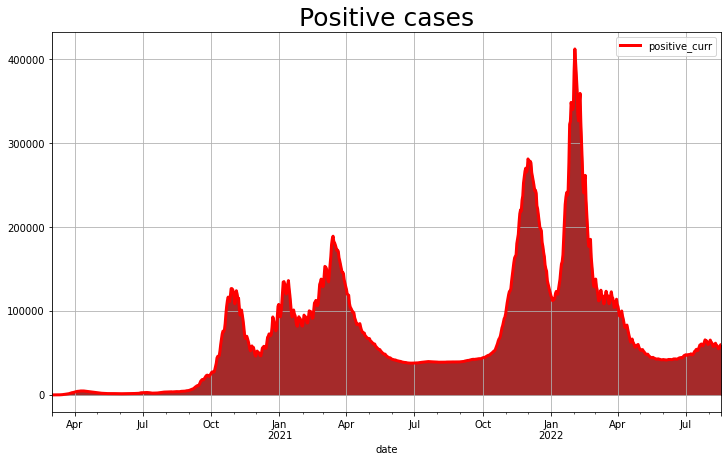

In [115]:
ax = corona.plot(x='date', y='positive_curr', figsize=(12,7), grid=True, lw=3, color='red')

# Pandas does not convert pandas series of datetime64 to something matplotlib can recognize,
# fill_between will have no effect, thats why we're creating a numpy array, more on this: https://stackoverflow.com/questions/29329725/pandas-and-matplotlib-fill-between-vs-datetime64
d = corona['date'].values

ax.fill_between(d,  0, corona['positive_curr'], color='brown')
ax.set_title("Positive cases", fontsize=25) 

### Tests done.

Text(0.5, 1.0, 'Tests done')

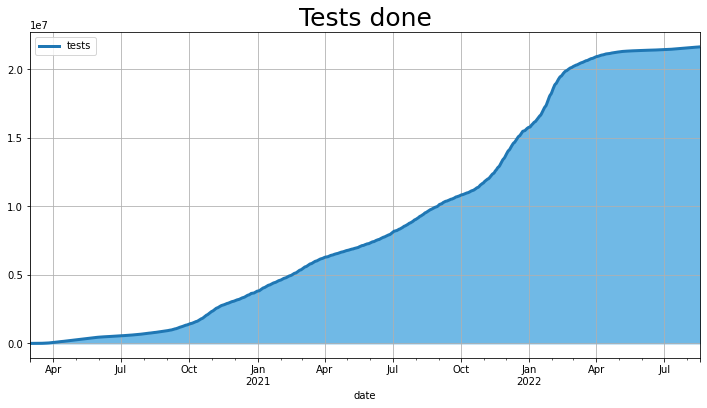

In [116]:
ax = corona.plot(x='date', y='tests', figsize=(12,6), grid=True, lw=3)

ax.fill_between(d, 0, corona['tests'], color='#70b9e6')
ax.set_title('Tests done', fontsize=25)

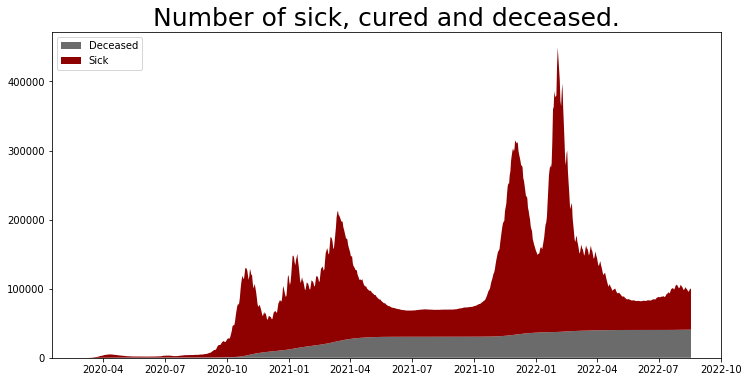

In [117]:
colors = ['#6b6b6b','#8f0101']
fig, ax = plt.subplots(figsize=(12,6))
ax.stackplot(d, corona['deaths'], corona['positive_curr'], labels=('Deceased', 'Sick'), colors=colors)
ax.legend(loc='upper left')
ax.set_title('Number of sick, cured and deceased.', fontsize=25)
plt.show()

Positive cases in logarithmic scale.

Text(0.5, 1.0, 'Positive cases in logarithmic scale.')

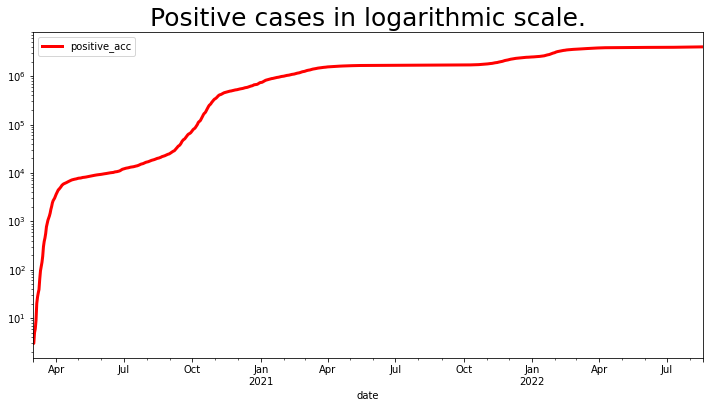

In [118]:
ax = corona.plot(x='date', y='positive_acc', color='red', figsize=(12,6),lw=3, logy=True)
ax.set_title("Positive cases in logarithmic scale.", fontsize=25)

Daily positives summed up for each month.

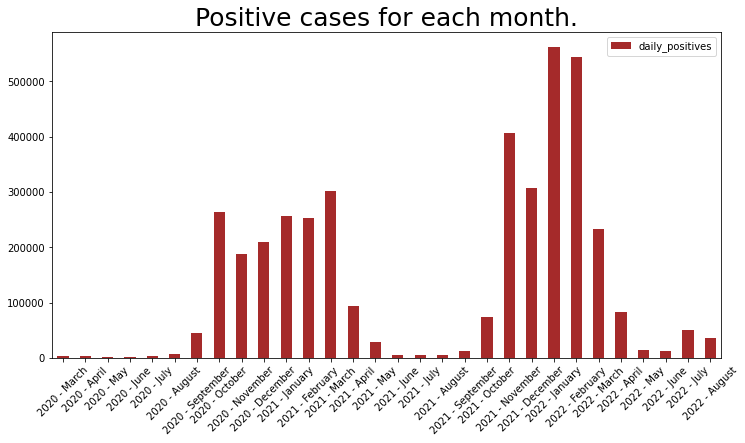

In [119]:
import matplotlib.ticker as ticker
# Group up the values by month and sum other rows
g = corona.groupby([corona.date.dt.year, corona.date.dt.month]).sum()
# Change the index values so ticks in graphs are prettier
g.index = map(lambda x: "{} - {}".format(x[0], calendar.month_name[x[1]]), g.index)

ax = g.plot( y='daily_positives', kind='bar',figsize=(12,6), color='brown', rot=0)
ax.set_title("Positive cases for each month.", fontsize=25)
plt.xticks(rotation=45)
display()


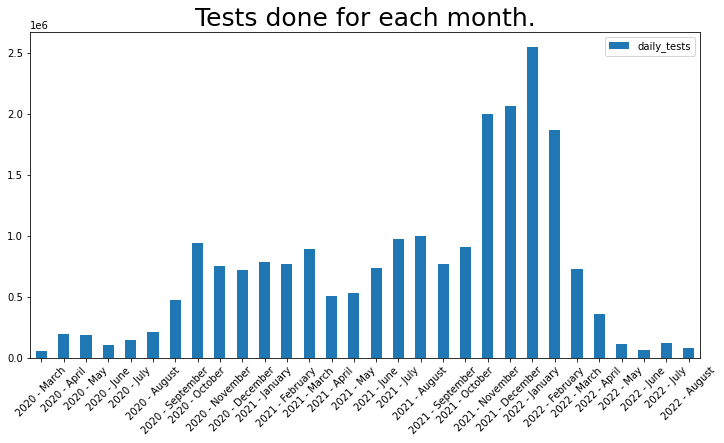

In [120]:
ax = g.plot(y='daily_tests', kind='bar', figsize=(12,6), rot=0)
ax.set_title("Tests done for each month.", fontsize=25)
plt.xticks(rotation=45)
display()

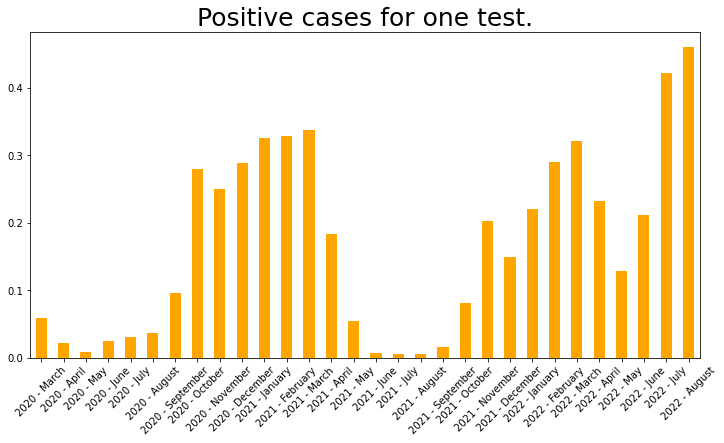

In [121]:
tmp_row =  g["daily_positives"] / g["daily_tests"]
ax = tmp_row.plot(color='orange', kind='bar', figsize=(12,6), rot=0)
ax.set_title("Positive cases for one test.", fontsize=25)
plt.xticks(rotation=45)
display()

In [122]:
def bar_plot(y, title=None, color='brown'):
    # Format function to return 'day'.'month'. from datetime.
    def line_format(x):
        return "{}.{}.".format(x.date().day, x.date().month)

    # Get the last fourteen rows.
    corona_last = corona[-14:]
    fig, ax = plt.subplots(figsize=(12,6))

    # Plot last fourteen days.
    bars = ax.bar(corona_last['date'], corona_last[y], color=color)

    # Create the x_ticks from the dates, also format them.
    ax.set_xticks(corona_last['date'])
    ax.set_xticklabels(map(lambda x : line_format(x), corona_last.date))

    if(title is not None):
        ax.set_title(title, fontsize=25)

    # For each bar, write the number of cases (which is the bar height) at the top.
    for rect in bars:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height + height/100, '{}'.format(int(height)), ha='center', va='bottom', weight='heavy')
    plt.show()

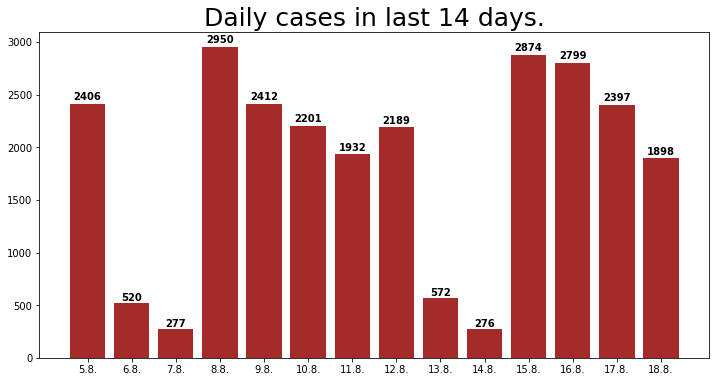

In [123]:
bar_plot('daily_positives', 'Daily cases in last 14 days.')

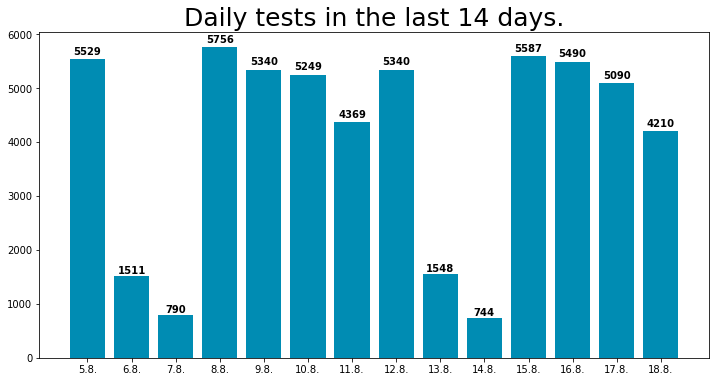

In [124]:
bar_plot('daily_tests', 'Daily tests in the last 14 days.', color='#008cb3')

# Exponential growth.
Plot exponential through the data and check if it still grows exponentially.
Inspired by https://kam.fit.cvut.cz/deploy/coronavirus/ by Tomáš Kalvoda.

We will use the following exponential function. Lets briefly analyze it first.
$$ amplitude \cdot e^{x/decay} $$

In [125]:
def exp_decay(x, ampl, decay):
    return ampl * np.exp(x / decay)

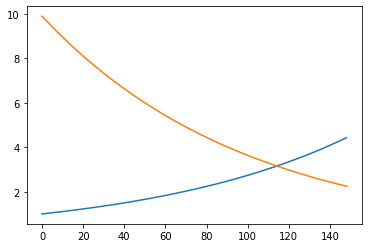

In [126]:
exp_values_neg = [exp_decay(x, 10, -100) for x in range(1, 150)]
exp_values = [exp_decay(x, 1, 100) for x in range(1, 150)]

plt.plot(range(0,len(exp_values)), exp_values)
plt.plot(range(0,len(exp_values_neg)), exp_values_neg)
plt.show()

We will have to have bigger amplitude.

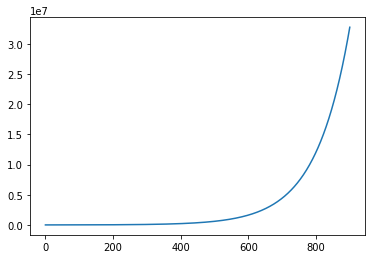

In [127]:
sugg_ampl, sugg_decay = 4000, 100
exp_values = [exp_decay(x, sugg_ampl, sugg_decay) for x in range(1, len(corona.index) + 1)]
plt.plot(range(0, len(exp_values)), exp_values)
plt.show()

Now, we need to give curve_fit a push to make it work, lets give it the values we guessed as a starting point.

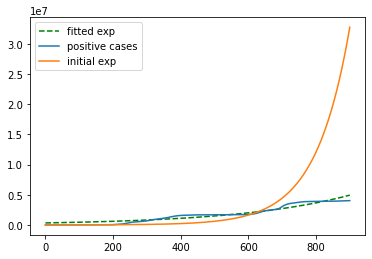

Amplitude: 328841.9469851946, Decay: 332.36566217017156


In [128]:
popt, pcov = curve_fit(exp_decay, corona['day'], corona['positive_acc'], p0=[sugg_ampl, sugg_decay])
plt.plot(corona['day'], exp_decay(corona['day'], *popt), 'g--', label='fitted exp')
plt.plot(corona['day'], corona['positive_acc'], label='positive cases')
plt.plot(corona['day'], exp_values, label='initial exp')
plt.legend()
plt.show()
print("Amplitude: {}, Decay: {}".format(popt[0], popt[1]))


Quotient by which positive cases go up every day.

In [129]:
q=np.exp(1/popt[1])
q

1.0030132651807098

Which is approx.

In [130]:
print( '{:.2f}% increase every day'.format((q - 1) * 100))

0.30% increase every day


## Calculate quotient for every day

In [131]:
# Here we will use more advanced model, which uses the same function but has -x in the exponent instead of x.
from lmfit.models import ExponentialModel

# Create new column
corona['quotient'] = 1.0

# Create the model
model = ExponentialModel()

# Iterate over all rows
for i, row in corona.iterrows():
    # Skip the first 10 rows, the jumps we're big so they wouldn't be accurate.
    if i < 10:
        continue
    
    # Get i+1 rows of our dataframe.
    tmpCorona = corona[:i+1]

    # Guess the initial parameters. We did this manually before, now lmfit does it for us.
    params = model.guess(tmpCorona['positive_acc'], x=tmpCorona['day'])
    
    # Get the actual fitted result.
    result = model.fit(tmpCorona['positive_acc'], params, x=tmpCorona['day'])
    
    # Save it to dataframe.
    corona.at[i, 'quotient'] = np.exp(-1/result.params['decay'])

In [132]:
corona.tail()

,date,positive_acc,cured,deaths,tests,kumulativni_pocet_ag_testu,prirustkovy_pocet_nakazenych,prirustkovy_pocet_vylecenych,prirustkovy_pocet_umrti,prirustkovy_pocet_provedenych_testu,prirustkovy_pocet_provedenych_ag_testu,positive_curr,daily_positives,daily_tests,day,quotient
896,2022-08-14,4012305,3957273,40667,21630871,33751204,276,2076,10,744,920,55032,276.0,744.0,896,1.003039
897,2022-08-15,4015179,3959586,40675,21636458,33756389,2874,2313,8,5587,5185,55593,2874.0,5587.0,897,1.003032
898,2022-08-16,4017978,3960096,40682,21641948,33760077,2799,510,7,5490,3688,57882,2799.0,5490.0,898,1.003026
899,2022-08-17,4020375,3960530,40696,21647038,33763504,2397,434,14,5090,3427,59845,2397.0,5090.0,899,1.003020
900,2022-08-18,4022273,3963956,40711,21651248,33767114,1898,3426,15,4210,3610,58317,1898.0,4210.0,900,1.003013


### Quotient evolution.

<AxesSubplot:xlabel='date'>

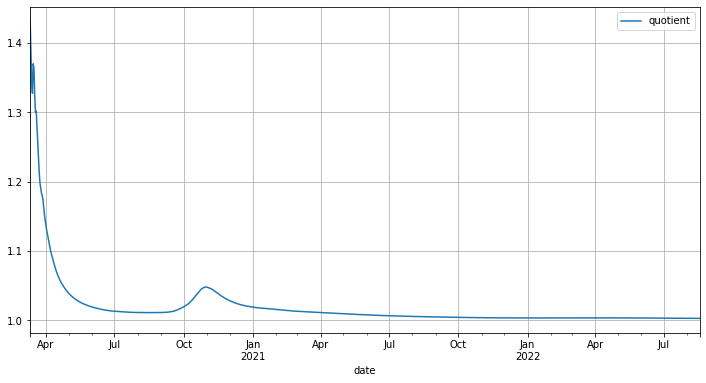

In [133]:
corona[10:].plot(x='date', y='quotient',  figsize=(12,6), grid=True)